In [1]:
import yaml
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NeighborhoodComponentsAnalysis
from sklearn.manifold import TSNE
import numpy as np

In [2]:
from sklearn.metrics import (
    f1_score, 
    confusion_matrix, 
    precision_score, 
    recall_score,
    accuracy_score,
    precision_recall_fscore_support
)

In [3]:
from collections import defaultdict

In [4]:
modality_colors = {
    'MIBI': (230./255, 159./255, 0./255), 
    'CODEX': (0./255, 114./255, 178./255), 
    'IMC': (0./255, 158./255, 115./255), 
    'MACSima': (213./255, 94./255, 0./255), 
    'IBEX': (204./255, 121./255, 167./255),
    'CellDIVE': (86./255, 180./255, 233./255),
}

with open('../data/combined_cell_type_mapping.yaml') as f:
    class_mapping_to_combined = yaml.safe_load(f)

with open('../data/celltype_colors.yaml') as f:
    ct_colors = yaml.safe_load(f)

## Confusion Matrix and Stratified Analysis

In [5]:
df_pred = pd.read_csv('../data/predictions.csv')

In [6]:
def plot_conf(cm):
    fig = plt.figure(figsize=(len(cm)/2, len(cm)/2))
    
    # annotate only diagonal entries
    annot = np.diag(np.diag(cm.to_numpy(), 0), 0)
    annot = np.round(annot, 1)
    annot = annot.astype("str")
    annot[annot == "0.0"] = ""

    ax = fig.add_axes([0.22, 0.2, 0.7, 0.7])

    axes = sns.heatmap(cm, annot=annot, fmt="", cmap="Blues", ax=ax, cbar=False)
    ax.patch.set_edgecolor("black")
    ax.patch.set_linewidth(2)

    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.grid(alpha=0.8)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

    plt.setp(ax.get_xticklabels(), ha="right", rotation=45)

In [7]:
class_names = df_pred['cell_type_actual_str'].unique()
cm = confusion_matrix(df_pred['cell_type_actual_str'], df_pred['cell_type_pred_str'], labels=class_names)
cm = pd.DataFrame(cm, columns=class_names, index=class_names)
cm = cm.div(cm.sum(axis=1), axis=0)

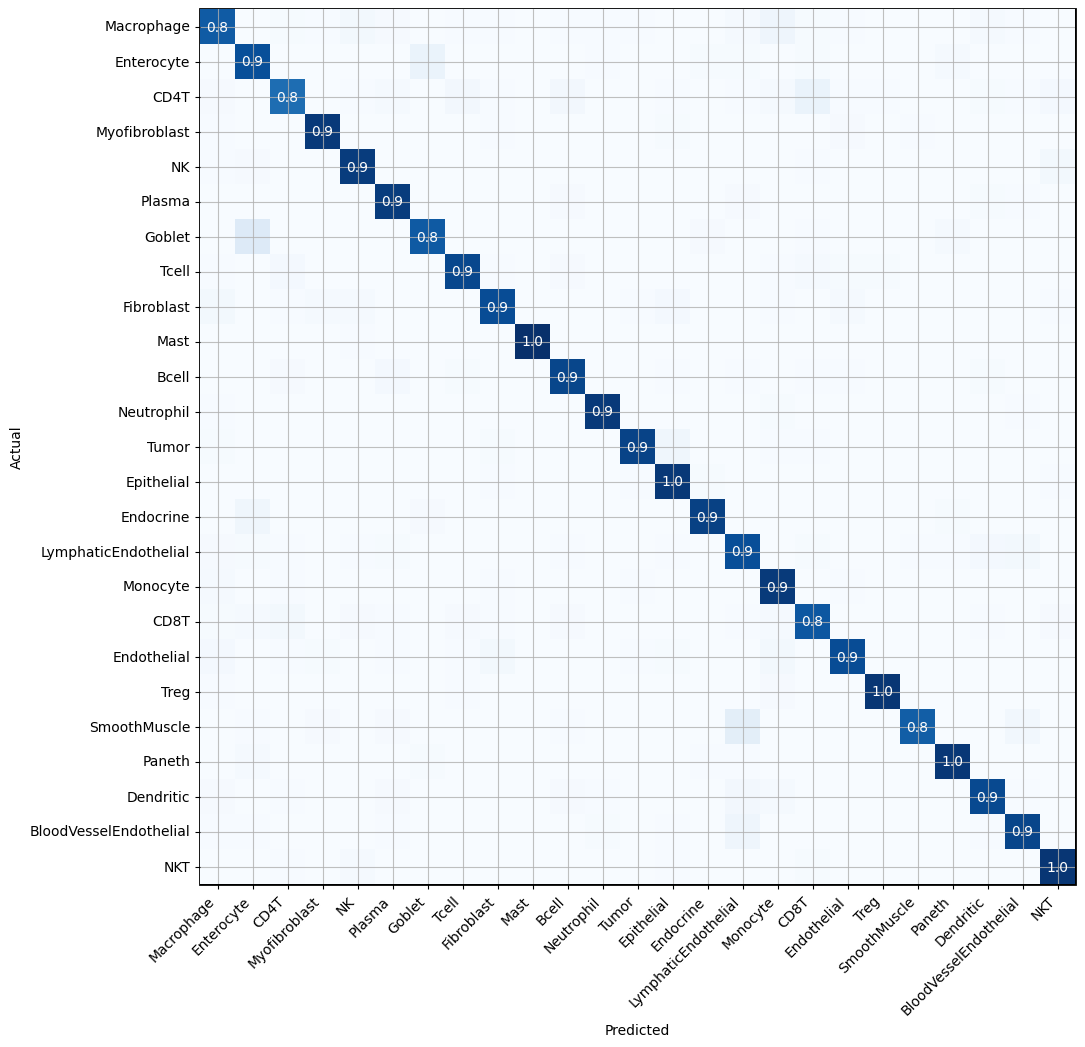

In [8]:
plot_conf(cm)

In [9]:
df_pred['cell_type_actual_combined_str'] = df_pred['cell_type_actual_str'].map(class_mapping_to_combined)
df_pred['cell_type_pred_combined_str'] = df_pred['cell_type_pred_str'].map(class_mapping_to_combined)

In [10]:
# calculate f1 score for each combined celltype
celltype_f1_scores_combined = defaultdict(list)
for celltype_name, subdf in df_pred.groupby("cell_type_actual_combined_str"):
    for ds_name, ds_subdf in subdf.groupby("dataset_name"):
        if len(ds_subdf.cell_type_actual_str) < 50: # drop the data points with less than 50 examples
            continue
        ds_subdf = ds_subdf.dropna()
        f1 = f1_score(
            ds_subdf.cell_type_actual_combined_str,
            ds_subdf.cell_type_pred_combined_str, 
            average="weighted",
            zero_division=np.nan,
            )

        celltype_f1_scores_combined[celltype_name].append(f1)

/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/tmp/ipykernel_4068754/264776211.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


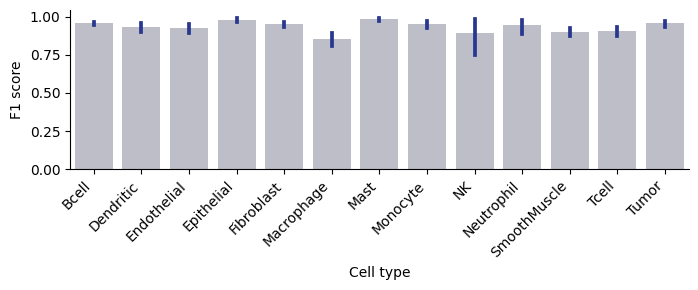

In [11]:
fig, ax = plt.subplots(figsize=(7, 3))
df_celltype_f1_combined = pd.DataFrame.from_dict(celltype_f1_scores_combined, orient='index').transpose()
sns.barplot(data=df_celltype_f1_combined, ax=ax, color='#bbbdc9', errcolor='#283890')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.xlabel('Cell type')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

In [12]:
# calculate f1 score for each domain
domain_f1_scores = defaultdict(list)
for domain_name, subdf in df_pred.groupby("modality_name"):
    for ds_name, ds_subdf in subdf.groupby("dataset_name"):
        if len(ds_subdf.cell_type_actual_str) < 50: # drop the data points with less than 50 examples
            continue
        f1 = f1_score(
            ds_subdf.cell_type_actual_str,
            ds_subdf.cell_type_pred_str, 
            average="weighted",
            zero_division=np.nan,
            )
        domain_f1_scores[domain_name].append(f1)

/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/tmp/ipykernel_4068754/2624051774.py:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


(0.0, 1.08)

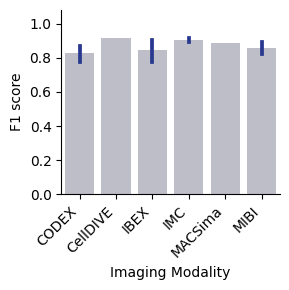

In [13]:
fig, ax = plt.subplots(figsize=(3, 3))
df_domain_f1 = pd.DataFrame.from_dict(domain_f1_scores, orient='index').transpose()
sns.barplot(data=df_domain_f1, ax=ax, color='#bbbdc9', errcolor='#283890')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.xlabel('Imaging Modality')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()
plt.ylim([0, 1.08])


In [14]:
# calculate f1 score for each tissue
tissue_f1_scores = defaultdict(list)
for tissue_name, subdf in df_pred.groupby("tissue_name"):
    for ds_name, ds_subdf in subdf.groupby("dataset_name"):
        if len(ds_subdf.cell_type_actual_str) < 50: # drop the data points with less than 50 examples
            continue
        f1 = f1_score(
            ds_subdf.cell_type_actual_str,
            ds_subdf.cell_type_pred_str, 
            average="weighted",
            zero_division=np.nan
            )
        tissue_f1_scores[tissue_name].append(f1)

/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/home/julie/anaconda3/lib/python3.10/site-pack

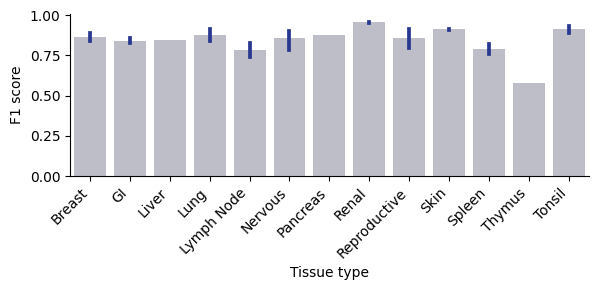

In [15]:
fig, ax = plt.subplots(figsize=(6, 3))
df_tissue_f1 = pd.DataFrame.from_dict(tissue_f1_scores, orient='index').transpose()
df_tissue_f1 = df_tissue_f1.rename({'Lymph_Node': 'Lymph Node'}, axis=1)
sns.barplot(data=df_tissue_f1, ax=ax, color='#bbbdc9', errcolor='#283890')
plt.setp(ax.get_xticklabels(), ha="right", rotation=45)
plt.tight_layout()
plt.xlabel('Tissue type')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()

## Zero-Shot Analysis

In [16]:
combined_celltype_names = [item for item in set(list(class_mapping_to_combined.values())) if not pd.isnull(item)]

In [17]:
def cal_f1_by_expr(df, class_names, gt_name, pred_name):
    f1_list = []
    precision_list = []
    recall_list = []
    accuracy_list = []
    support_list = []
    for expr_name, subdf in df.groupby('expr_name'):
        
        precision, recall, f1, support = precision_recall_fscore_support(subdf[gt_name], subdf[pred_name], average=None, labels=class_names, zero_division=np.nan)
        if np.any(support <= 500): # drop the data points with less than 500 examples
            f1[support <= 500] = np.nan

        f1[support==0] = np.nan 
        precision[support==0] = np.nan
        recall[support==0] = np.nan
        f1_list.append(f1)
        precision_list.append(precision)
        recall_list.append(recall)
        support_list.append(support)
    df_f1_score = pd.DataFrame(f1_list, columns=class_names)
    df_precision_score = pd.DataFrame(precision_list, columns=class_names)
    df_recall_score = pd.DataFrame(recall_list, columns=class_names)
    df_support = pd.DataFrame(support_list, columns=class_names)
    return df_f1_score, df_precision_score, df_recall_score, df_support

In [18]:
df_ours = pd.read_csv('../data/zero_shot_ours.csv')

df_ours['cell_type_actual_combined_str'] = df_ours['cell_type_actual_str'].map(class_mapping_to_combined)
df_ours['cell_type_pred_combined_str'] = df_ours['cell_type_pred_str'].map(class_mapping_to_combined)

In [19]:
df_xgboost = pd.read_csv('../data/zero_shot_xgboost.csv')

df_xgboost['cell_type_actual_combined_str'] = df_xgboost['cell_type_actual_str'].map(class_mapping_to_combined)
df_xgboost['cell_type_pred_combined_str'] = df_xgboost['cell_type_pred_str'].map(class_mapping_to_combined)

In [20]:
df_maps = pd.read_csv('../data/zero_shot_maps.csv')

df_maps['cell_type_actual_combined_str'] = df_maps['cell_type_actual_str'].map(class_mapping_to_combined)
df_maps['cell_type_pred_combined_str'] = df_maps['cell_type_pred_str'].map(class_mapping_to_combined)

In [21]:
f1_ours_per_expr, precision_ours_per_expr, recall_ours_per_expr, support_ours_per_expr = cal_f1_by_expr(
    df_ours, 
    combined_celltype_names, 
    'cell_type_actual_combined_str', 
    'cell_type_pred_combined_str'
)

In [22]:
f1_xgboost_per_expr, precision_xgboost_per_expr, recall_xgboost_per_expr, support_xgboost_per_expr = cal_f1_by_expr(
    df_xgboost, 
    combined_celltype_names, 
    'cell_type_actual_combined_str', 
    'cell_type_pred_combined_str'
)

In [23]:
f1_maps_per_expr, precision_maps_per_expr, recall_maps_per_expr, support_maps_per_expr = cal_f1_by_expr(
    df_maps, 
    combined_celltype_names, 
    'cell_type_actual_combined_str', 
    'cell_type_pred_combined_str'
)

In [24]:
# Merge all F1 scores together
f1_xgboost_per_expr['Method'] = 'XGBoost'
f1_ours_per_expr['Method'] = 'Ours'
f1_maps_per_expr['Method'] = 'MAPS'

df_f1_score_per_expr = pd.concat([f1_xgboost_per_expr, f1_maps_per_expr, f1_ours_per_expr])

df_f1_score_per_expr_melted = df_f1_score_per_expr.melt(id_vars='Method', var_name='Class', value_name='F1_Score')
df_f1_score_per_expr_melted = df_f1_score_per_expr_melted[df_f1_score_per_expr_melted['Class'] != 'Neuron']
df_f1_score_per_expr_melted = df_f1_score_per_expr_melted.dropna()

In [25]:
df_f1_score_per_expr_melted['Method'] = pd.Categorical(df_f1_score_per_expr_melted['Method'], ordered=True, 
                              categories= ['XGBoost', 'MAPS', 'Ours'])

In [26]:
df_f1_score_per_expr_melted = df_f1_score_per_expr_melted.sort_values(['Method','Class'])

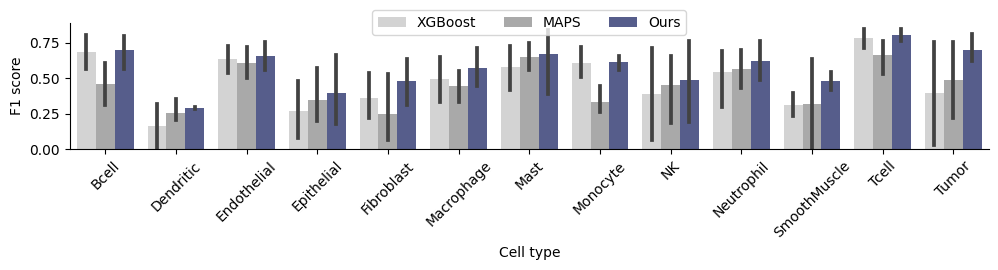

In [27]:
my_palette = ['lightgrey', 'darkgrey', '#4d5794']
fig, ax = plt.subplots(figsize=(10, 2.8))
sns.barplot(x='Class', y='F1_Score', hue='Method', data=df_f1_score_per_expr_melted, palette=my_palette)
plt.xticks(rotation=45)
plt.xlabel('Cell type')
plt.ylabel('F1 score')
ax.spines[['right', 'top']].set_visible(False)
plt.legend(loc='center', bbox_to_anchor=(0.5, 1), ncols=3)
plt.tight_layout()


## Embedding Visualization

In [28]:
data = np.load('../data/embeddings.npz')
cls_token_embedding = data['cls_token_embedding']
ct_str = data['ct_str']
modality_str = data['modality_str']

ct_str_combined = [class_mapping_to_combined[ct] for ct in ct_str]

In [29]:
X = cls_token_embedding
y = ct_str_combined

# Perform NCA
nca = NeighborhoodComponentsAnalysis(random_state=0, n_components=10)
X_new = nca.fit_transform(X, y)

# Perform t-SNE
tsne = TSNE(n_components=2, random_state=0, perplexity=50)
embeddings_2d = tsne.fit_transform(X_new)

# Create a DataFrame for plotting
df_tsne = pd.DataFrame({
    'x': embeddings_2d[:, 0],
    'y': embeddings_2d[:, 1],
    'domain_str': modality_str,
    'ct_str': ct_str_combined,
})

# Shuffle the DataFrame
df_tsne_shuffled = df_tsne.sample(frac=1)

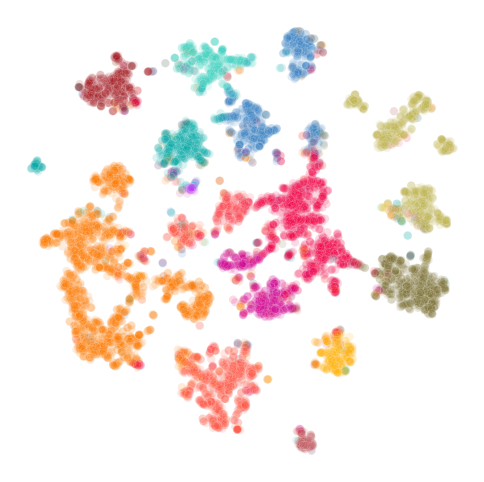

In [30]:
fig, ax1 = plt.subplots(figsize=(6,6))

sns.scatterplot(x='x', y='y', hue='ct_str', data=df_tsne_shuffled, palette=ct_colors, alpha=0.15, 
                ax=ax1, legend=None)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_xlabel('')
ax1.set_ylabel('')
ax1.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

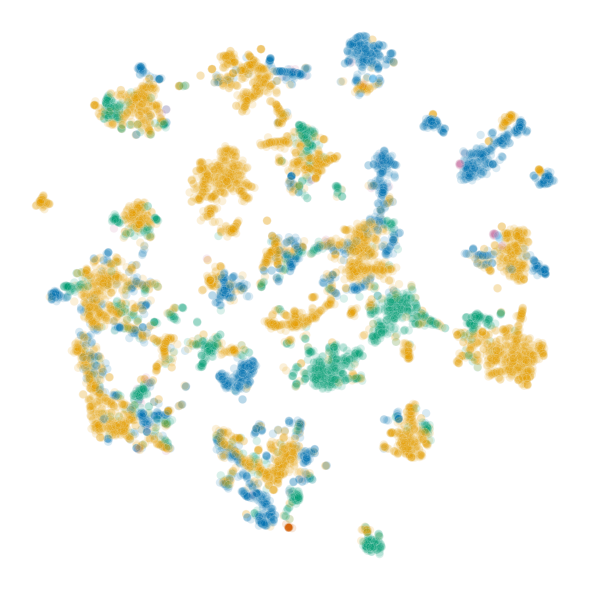

In [31]:
fig, ax2 = plt.subplots(figsize=(6,6))

sns.scatterplot(x='x', y='y', hue='domain_str', data=df_tsne_shuffled, palette=modality_colors, alpha=0.15, 
                ax=ax2, style_order=['MIBI', 'CODEX', 'IMC', 'MACSima', 'IBEX', 'CellDIVE'], legend=False)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_xlabel('')
ax2.set_ylabel('')
ax2.spines[['right', 'top', 'left', 'bottom']].set_visible(False)

plt.tight_layout()


## Marker Positivity

In [34]:
data = np.load('../data/marker_positivity.npz')
marker_pos_gt = data['marker_pos_gt']
marker_pos_pred = data['marker_pos_pred']
ch_idx = data['ch_idx']
dataset_name_str = data['dataset_name_str']
ct_str = data['ct_str']
ct_pred_str = data['ct_pred_str']

In [35]:
f1_score_list = []
precision_score_list = []
recall_score_list = []
accuracy_score_list = []
for ds_str in np.unique(dataset_name_str):
    mask_ds = dataset_name_str == ds_str
    mp_gt = marker_pos_gt[mask_ds]
    mp_pred = marker_pos_pred[mask_ds]
    mp_ch_list = ch_idx[mask_ds]
    
    unique_chs = np.unique(mp_ch_list)
    unique_chs = unique_chs[unique_chs >= 0] # drop the '-1', used for padding
    
    for idx in unique_chs:
        ch_mask = mp_ch_list == idx

        f = f1_score(mp_gt[ch_mask], mp_pred[ch_mask], zero_division=np.nan)
        p = precision_score(mp_gt[ch_mask], mp_pred[ch_mask], zero_division=np.nan)
        r = recall_score(mp_gt[ch_mask], mp_pred[ch_mask], zero_division=np.nan)
        a = accuracy_score(mp_gt[ch_mask], mp_pred[ch_mask])

        f1_score_list.append(f)
        precision_score_list.append(p)
        recall_score_list.append(r)
        accuracy_score_list.append(a)


In [36]:
df_marker_pos = pd.DataFrame({
    'Accuracy': accuracy_score_list, 
    'Precision': precision_score_list,
    'Recall': recall_score_list,
    'F1': f1_score_list,
})

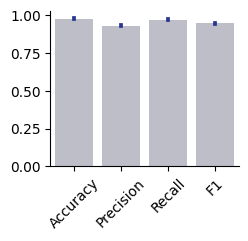

In [37]:
fig, ax = plt.subplots(figsize=(2.5,2.5))
sns.barplot(df_marker_pos, ax=ax, color='#bbbdc9',  errcolor='#283890')
plt.xticks(rotation=45)
ax.spines[['right', 'top']].set_visible(False)
plt.tight_layout()